In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [2]:
# 1. 데이터 로드
file_path = "dataset/jena_climate_2009.csv"
data = pd.read_csv(file_path)

In [3]:
# 데이터 확인
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
# 'T (degC)' 열이 기온 데이터
temperature = data['T (degC)'].values

In [5]:
# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1)) # 정규화
scaled_data = scaler.fit_transform(temperature.reshape(-1, 1))

In [6]:
# 데이터셋 생성 함수
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [7]:
look_back = 60 # 과거 60시간 데이터를 기반으로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [10]:
# 데이터 분리
train_size = int(len(X) * 0.8)  # 80% 학습 데이터
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
# 3. RNN 모델 구성
model = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(1)
])

c:\AIProject\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# 4. 모델 학습
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0023 - val_loss: 1.0388e-04
Epoch 2/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.6727e-05 - val_loss: 1.0663e-04
Epoch 3/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.4596e-05 - val_loss: 6.1879e-05
Epoch 4/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.1435e-05 - val_loss: 7.8819e-05
Epoch 5/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.1339e-05 - val_loss: 7.4810e-05


In [14]:
# 5. 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # 정규화 복원

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [15]:
# 실제 값 복원
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

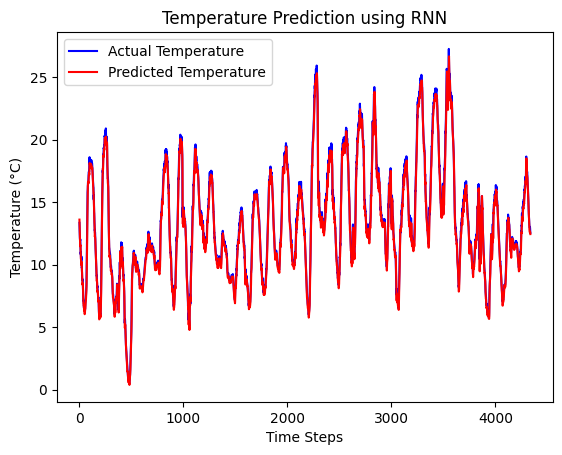

In [17]:
# 6. 시각화
plt.Figure(figsize=(14, 5))
plt.plot(actual_values, label="Actual Temperature", color='blue')
plt.plot(predictions, label="Predicted Temperature", color='red')
plt.title('Temperature Prediction using RNN')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

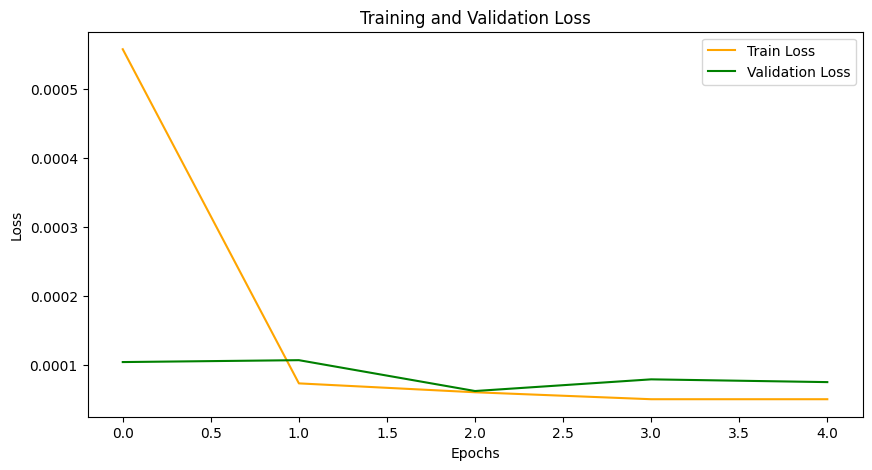

In [18]:
# 7. 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()